# Siamese neural networks for one-shot image recognition - Assignment 2

Assignment #2 in "Introduction to Deep Learning" course

Inspired by [Siamese neural networks for one-shot image recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

# Imports & Env. Variables

In [128]:
# Visualizations
import matplotlib.pyplot as plt

# Math & Containers
import numpy as np
import pandas as pd
import math

# Keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping

# SKLearn
from sklearn.model_selection import train_test_split

# Image Processing
import matplotlib.image as mpimg

# Misc
import time
import random
import os

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
BASE_DIR = './drive/My Drive/Colab Notebooks/Deep Learning - gilad/Assignment 2/'
DATA_DIR = os.path.join(BASE_DIR, 'lfwa')
INPUT_SHAPE = (150, 150, 1)

In [0]:
def plot_acc(history, has_val=False):
    """
    summarize history for accuracy

    :param history - keras history object
    :param has_val - if validation set was included in the training process
    """
    plt.plot(history_vgg.history['acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    
def plot_loss(history, has_val=False):
    """
    summarize history for loss

    :param history - keras history object
    :param has_val - if validation set was included in the training process
    """
    plt.plot(history_vgg.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
def plot_misclassification_examples(model, generator):
    """
    Plots examples of mislcassification by the model.
    
    :param model - keras model
    :param generator - generator object to retrieve batches of data
    """
    
    batch = next(generator)
    x1, x2 = batch[0]
    y = batch[1]
    
    preds = np.rint(model.predict([x1, x2])).flatten()
    
    mc1 = x1[preds != y,...]
    mc2 = x2[preds != y,...]
    
    y = y[preds != y]
    
    if mc1.shape[1] == 3:
        mc1 = np.moveaxis(mc1, 1, 3)
        mc2 = np.moveaxis(mc2, 1, 3)
    
    print_pair(mc1[0], mc2[0], y[0])
    
    def lbl_tostring(lbl):
      return 'Same Person' if lbl==1 else 'Different Person'
    
    print('Correct Label: {}\nModel Prediction: {}'.format(lbl_tostring(y[0]), lbl_tostring(preds[0])))

# Data Exploration

In [0]:
train = np.load(os.path.join(BASE_DIR, 'train.npy'), allow_pickle=True)
test = np.load(os.path.join(BASE_DIR, 'test.npy'), allow_pickle=True)

In [0]:
def print_pair(img1, img2, y):
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap='gray')
    plt.show()
    
def print_random_pair(X):
  rnd_idx = np.random.randint(X.shape[0])

  img1 = X[rnd_idx][0] # img 1
  img2 = X[rnd_idx][1] # img 2
  tlbl = X[rnd_idx][2]

  print('Label is: {} - {}'.format(tlbl, 'Same Person' if tlbl==1 else 'Different Person'))
  print_pair(img1, img2, tlbl)

Label is: 1 - Same Person


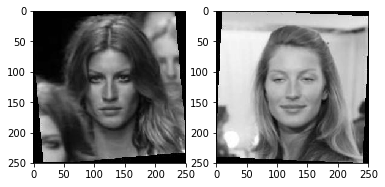

In [0]:
print_random_pair(train)

### Train Set ###
Number of examples: 2200


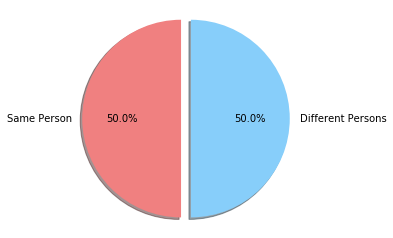

### Test Set ###
Number of examples: 1000


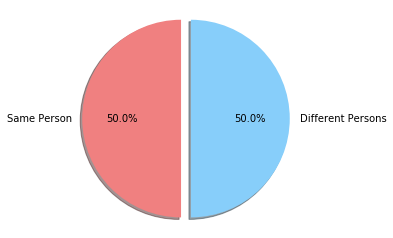

Number of unique people in train and test sets: 5749


In [0]:
def print_stats(x):
    y = x[...,2]
    print('Number of examples: {}'.format(x.shape[0]))
    
    # Data to plot
    labels = 'Same Person', 'Different Persons'
    sizes = [y.sum(), len(y)-y.sum()]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0,)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=90)

    plt.axis('equal')
    plt.show()

print('### Train Set ###')
print_stats(train)
print('### Test Set ###')
print_stats(test)

print('Number of unique people in train and test sets: {}'.format(len(os.listdir(DATA_DIR))))

In [0]:
del train, test

# Data Preparation

In [0]:
# read the train/test info and arrange it as twins matrix
def get_data_matrix(set_type):
  
    filename = 'pairsDev{}.txt'.format(set_type)
    path = os.path.join(BASE_DIR, filename)
  
    train = pd.read_csv(path, header = None)
    x = train[0]
    mat = []
    for i in range(1, len(x)):
        cSplited = x[i].split('\t') 
        if len(cSplited) == 3:     # label 1 same person
            name1 = cSplited[0]
            picN1 = cSplited[1].zfill(4)
            name2 = cSplited[0]
            picN2 = cSplited[2].zfill(4)
            label = 1
        else:
            name1 = cSplited[0]
            picN1 = cSplited[1].zfill(4)
            name2 = cSplited[2]
            picN2 = cSplited[3].zfill(4)
            label = 0
            
        mat.append([name1, picN1, name2, picN2, label])
    #endfor
    
    return np.array(mat)

def get_img_path(person, idx):
    filename = '{}_{}.jpg'.format(person, idx)
    aux = [DATA_DIR, person, filename]
    res = os.path.join(*aux)
    return res
  
def read_data(matrix):
    x = []

    for entry in matrix:
        img_path_1 = get_img_path(entry[0], entry[1])
        img_path_2 = get_img_path(entry[2], entry[3])

        pic1 = mpimg.imread(img_path_1)
        pic2 = mpimg.imread(img_path_2)

        x.append((pic1, pic2, entry[4].astype(np.int)))
    #endfor
    
    x = np.array(x)
    y = np.array([entry[4].astype(np.int) for entry in matrix])
    
    return (x, y)
  
  
def get_data_set(set_type):
    matrix = get_data_matrix(set_type)
    x, y = read_data(matrix)
    
    return x, y
  
def get_matrix_for_gen(set_type):
    filename = 'pairsDev{}.txt'.format(set_type)
    matrix_path = os.path.join(BASE_DIR, filename)
    matrix = get_data_matrix(matrix_path)
    
    final_matrix = []
    
    for entry in matrix:
        img_path_1 = get_img_path(entry[0], entry[1])
        img_path_2 = get_img_path(entry[2], entry[3])
        lbl = entry[4].astype(np.int)
        
        final_matrix.append([img_path_1, img_path_2, lbl])
    
    final_matrix = np.array(final_matrix)

    return final_matrix
    

In [0]:
# Create npy files to load later

# train = get_data_set('Train')
# test = get_data_set('Test')

# np.save(os.path.join(BASE_DIR, 'train'), train)
# np.save(os.path.join(BASE_DIR, 'test'), test)

# Data Generators

In [0]:
def generator(samples, channels=1, crop=True, batch_size=32, channels_last=True):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        np.random.shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X1_train = []
            X2_train = []
            y_train = []
            
            X1_train = np.stack(batch_samples[:,0]).reshape(len(batch_samples[:,0]),250,250)
            X2_train = np.stack(batch_samples[:,1]).reshape(len(batch_samples[:,0]),250,250)
            
            if crop:
                X1_train = X1_train[:,50:200,50:200]
                X2_train = X2_train[:,50:200,50:200]
            
            # Normalize for faster convergence
            X1_train = X1_train / 255.
            X2_train = X2_train / 255.
            
            # Placeholders
            final_X1 = np.empty((X1_train.shape[0], X1_train.shape[1], X1_train.shape[2], channels))
            final_X2 = np.empty((X2_train.shape[0], X2_train.shape[1], X2_train.shape[2], channels))
            
            # Duplicate channels if needed
            for i in range(channels):
              final_X1[...,i] =  X1_train
              final_X2[...,i] =  X2_train
            
            if not channels_last:
              final_X1 = np.moveaxis(final_X1, 3, 1)
              final_X2 = np.moveaxis(final_X2, 3, 1)
            
            y_train = batch_samples[:,2]           
            yield [final_X1, final_X2], y_train

# Validation Strategy

In [0]:
train_matrix = get_data_matrix('Train')
# test_matrix = get_data_matrix('Test')
train_samples = np.load(os.path.join(BASE_DIR, 'train.npy'), allow_pickle=True)
full_train = np.hstack([train_samples, train_matrix])

In [0]:
def val_split(data):
    val_ppl = os.listdir(DATA_DIR)[:600]
    val_rows = []
    val_lbls = 0
    val_idx = []

    for i, row in enumerate(data):
        if row[3] in val_ppl or row[5] in val_ppl:
            val_rows.append(row)
            val_idx.append(i)
            if row[2]==1:
                val_lbls = val_lbls + 1
              
    val_rows = np.array(val_rows)
    val_0 = val_rows[val_rows[...,2]==0][:val_lbls]
    val_1 = val_rows[val_rows[...,2]==1]
    
    val_rows = np.vstack([val_0, val_1])
    
    print('Validation set includes {} samples, of which {} are labeled 1 - same person'.format(len(val_rows), val_lbls))
    
    data = np.delete(data, val_idx, axis=0)
    
    return val_rows, data

In [0]:
# Load data
train_samples = np.load(os.path.join(BASE_DIR, 'train.npy'), allow_pickle=True)
validation_samples, train_samples = val_split(full_train)
test_samples = np.load(os.path.join(BASE_DIR, 'test.npy'), allow_pickle=True)

# Model 1 - Koch et al.


Includes cropping of images

In [101]:
img_shape = INPUT_SHAPE


# build the model according to the paper
def W_init(shape):
    name = None
    values = np.random.normal(loc=0,scale=1e-2,size=shape) # Initialize weights as in paper
    return K.variable(values,name=name)
  
def b_init(shape):
    name = None
    values = np.random.normal(loc=0.5,scale=1e-2,size=shape) # Initialize bias as in paper
    return K.variable(values,name=name)

def get_model():
    left_input = Input(img_shape)
    right_input = Input(img_shape)
    net = Sequential()
    net.add(Conv2D(64,(10,10), activation='relu', input_shape = img_shape, kernel_initializer=W_init, kernel_regularizer=l2(2e-4)))
    net.add(MaxPooling2D())
    net.add(Conv2D(128,(7,7), activation='relu', kernel_regularizer=l2(2e-4), kernel_initializer=W_init, bias_initializer=b_init))
    net.add(MaxPooling2D())
    net.add(Conv2D(128,(4,4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    net.add(MaxPooling2D())
    net.add(Conv2D(256,(4,4), activation='relu', kernel_initializer=W_init, kernel_regularizer=l2(2e-4), bias_initializer=b_init))
    net.add(Flatten())
    net.add(Dense(512, activation="tanh", kernel_regularizer=l2(1e-3), kernel_initializer=W_init, bias_initializer=b_init))

    # call the network model on each input tensor so the parameters are shared.
    encoded_l = net(left_input)
    encoded_r = net(right_input)
    
    #merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    
    #call this layer on list of two input tensors
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    optimizer = Adam(0.00006)

    siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['acc'])
    
    return siamese_net
  
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 512)          17055040    input_14[0][0]                   
                                                                 input_15[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 512)          0           sequential_11[1][0]              
          

In [0]:
# Create generator
train_generator = generator(train_samples, channels=1, batch_size=32)
validation_generator = generator(validation_samples, channels=1, batch_size=32)
test_generator = generator(test_samples, channels=1, batch_size=32)

In [104]:
epochs = 30
batch_size = 32
steps_per_epoch = len(train_samples) // batch_size
validation_steps = len(validation_samples) // batch_size
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=5, verbose=1, mode='auto')

start_time = time.time()

history = model.fit_generator(generator=train_generator, validation_data=validation_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs, callbacks=[early_stopping])

end_time = time.time()

print('Training process of %i epochs finished in %.2f seconds' % (len(history.epoch)-1, end_time - start_time))

Epoch 1/30
59/59 [==============================] - 13s 213ms/step - loss: 2.0224 - acc: 0.5514 - val_loss: 1.8084 - val_acc: 0.5000
Epoch 2/30
59/59 [==============================] - 9s 153ms/step - loss: 1.6119 - acc: 0.5773 - val_loss: 1.4856 - val_acc: 0.5352
Epoch 3/30
59/59 [==============================] - 9s 146ms/step - loss: 1.3542 - acc: 0.5902 - val_loss: 1.2981 - val_acc: 0.5070
Epoch 4/30
59/59 [==============================] - 9s 147ms/step - loss: 1.1921 - acc: 0.6166 - val_loss: 1.1574 - val_acc: 0.5704
Epoch 5/30
59/59 [==============================] - 9s 147ms/step - loss: 1.0963 - acc: 0.5705 - val_loss: 1.0953 - val_acc: 0.4930
Epoch 6/30
59/59 [==============================] - 9s 148ms/step - loss: 1.0112 - acc: 0.5844 - val_loss: 1.0126 - val_acc: 0.4930
Epoch 7/30
59/59 [==============================] - 9s 149ms/step - loss: 0.9577 - acc: 0.6000 - val_loss: 0.9646 - val_acc: 0.5437
Epoch 8/30
59/59 [==============================] - 9s 149ms/step - loss: 0

In [109]:
train_eval = model.evaluate_generator(validation_generator, steps=len(validation_samples)  // 32)
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=len(validation_samples)  // 32)
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_samples)  // 32)

print('Train Set -- Loss: %.2f -- Accuracy: %.2f' % (train_eval[0], train_eval[1]))
print('Validation Set -- Loss: %.2f -- Accuracy: %.2f' % (val_loss, val_acc))
print('Test Set -- Loss: %.2f -- Accuracy: %.2f' % (test_loss, test_acc))

Train Set -- Loss: 0.76 -- Accuracy: 0.57
Validation Set -- Loss: 0.76 -- Accuracy: 0.54
Test Set -- Loss: 0.73 -- Accuracy: 0.63


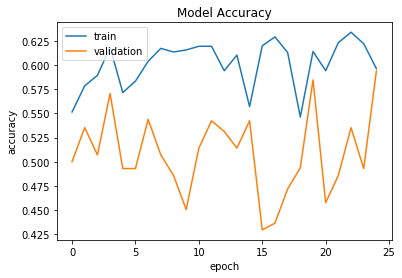

In [106]:
plot_acc(history, has_val=True)

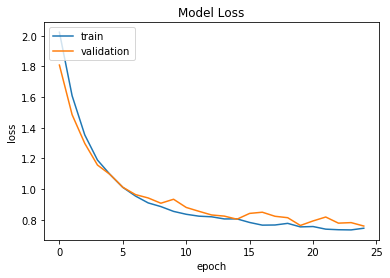

In [107]:
plot_loss(history, has_val=True)

# Model 2 - Transfer Learning - VGG16

In [0]:
def get_vgg_siamese():
    inp_shape = (150,150,3) # we have different size of pictures here
    inp_l = Input(inp_shape)
    inp_r = Input(inp_shape)
    
    vgg1 = VGG16(include_top=False, weights='imagenet', input_shape=inp_shape, pooling='max')
    for layer in vgg1.layers[:-5]:
       layer.trainable = False
    
    model = Sequential()
    model.add(vgg1)
    model.add(Dense(128, activation='tanh'))
    
    emb1 = model(inp_l)
    emb2 = model(inp_r)
    
    l1_calc = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    l1_dist = l1_calc([emb1, emb2])

    # the output calculated via sigmoid activation
    out = Dense(1,activation='sigmoid')(l1_dist)

    # final siames model
    model = Model(inputs=[inp_l, inp_r], outputs=out)
    
    # optimizer and compile
    opt = Adam(0.00006)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    
    return model

In [0]:
# Create generator
train_samples_full = np.load(os.path.join(BASE_DIR, 'train.npy'), allow_pickle=True)
train_generator = generator(train_samples_full, channels=3, batch_size=32)
# validation_generator = generator(validation_samples, channels=3, batch_size=32)
test_generator = generator(test_samples, channels=3, batch_size=32)

In [115]:
#######################
# Use generator to train neural network in Keras
#######################

# Create model in Keras
model_vgg = get_vgg_siamese()

# Fit model using generator
epochs = 30
batch_size = 32
steps_per_epoch = len(train_samples) // batch_size
validation_steps = len(validation_samples) // batch_size

start_time = time.time()

history_vgg = model_vgg.fit_generator(generator=train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)

end_time = time.time()

print('Training process of %i epochs finished in %.2f seconds' % (len(history_vgg.epoch)-1, end_time - start_time))

Epoch 1/30
59/59 [==============================] - 13s 220ms/step - loss: 0.6879 - acc: 0.5609
Epoch 2/30
59/59 [==============================] - 14s 234ms/step - loss: 0.5980 - acc: 0.7235
Epoch 3/30
59/59 [==============================] - 11s 193ms/step - loss: 0.5388 - acc: 0.7696
Epoch 4/30
59/59 [==============================] - 12s 196ms/step - loss: 0.4981 - acc: 0.7996
Epoch 5/30
59/59 [==============================] - 12s 196ms/step - loss: 0.4874 - acc: 0.8062
Epoch 6/30
59/59 [==============================] - 12s 197ms/step - loss: 0.4471 - acc: 0.8422
Epoch 7/30
59/59 [==============================] - 12s 199ms/step - loss: 0.4196 - acc: 0.8739
Epoch 8/30
59/59 [==============================] - 12s 197ms/step - loss: 0.4102 - acc: 0.8644
Epoch 9/30
59/59 [==============================] - 12s 201ms/step - loss: 0.4562 - acc: 0.8436
Epoch 10/30
59/59 [==============================] - 12s 201ms/step - loss: 0.4351 - acc: 0.8590
Epoch 11/30
59/59 [====================

In [150]:
train_eval = model_vgg.evaluate_generator(train_generator, steps=len(train_samples)  // 32)
test_loss, test_acc = model_vgg.evaluate_generator(test_generator, steps=len(test_samples)  // 32)

print('Train Set -- Loss: %.2f -- Accuracy: %.2f' % (train_eval[0], train_eval[1]))
print('Test Set -- Loss: %.2f -- Accuracy: %.2f' % (test_loss, test_acc))

Train Set -- Loss: 0.14 -- Accuracy: 0.98
Test Set -- Loss: 0.66 -- Accuracy: 0.65


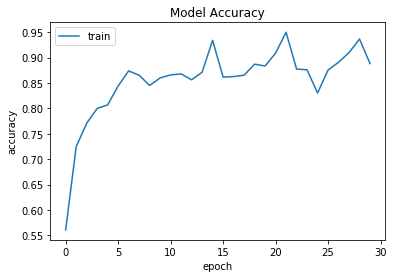

In [151]:
plot_acc(history_vgg)

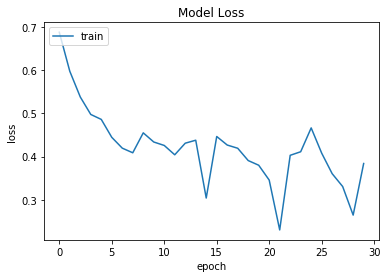

In [152]:
plot_loss(history_vgg)

# Model 3 - Transfer Learning - VGGFace

In [0]:
def vgg_face(weights_path=None):
    img = Input(shape=(3, 250, 250))

    pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
    conv1_1 = Convolution2D(64, (3, 3), activation='relu')(pad1_1)
    pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
    conv1_2 = Convolution2D(64, (3, 3), activation='relu')(pad1_2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

    pad2_1 = ZeroPadding2D((1, 1))(pool1)
    conv2_1 = Convolution2D(128, (3, 3), activation='relu')(pad2_1)
    pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
    conv2_2 = Convolution2D(128, (3, 3), activation='relu')(pad2_2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

    pad3_1 = ZeroPadding2D((1, 1))(pool2)
    conv3_1 = Convolution2D(256, (3, 3), activation='relu')(pad3_1)
    pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
    conv3_2 = Convolution2D(256, (3, 3), activation='relu')(pad3_2)
    pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
    conv3_3 = Convolution2D(256, (3, 3), activation='relu')(pad3_3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

    pad4_1 = ZeroPadding2D((1, 1))(pool3)
    conv4_1 = Convolution2D(512, (3, 3), activation='relu')(pad4_1)
    pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
    conv4_2 = Convolution2D(512, (3, 3), activation='relu')(pad4_2)
    pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
    conv4_3 = Convolution2D(512, (3, 3), activation='relu')(pad4_3)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

    pad5_1 = ZeroPadding2D((1, 1))(pool4)
    conv5_1 = Convolution2D(512, (3, 3), activation='relu')(pad5_1)
    pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
    conv5_2 = Convolution2D(512, (3, 3), activation='relu')(pad5_2)
    pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
    conv5_3 = Convolution2D(512, (3, 3), activation='relu')(pad5_3)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

    fc6 = Convolution2D(4096, (7, 7), activation='relu')(pool5)
    fc6_drop = Dropout(0.5)(fc6)
    fc7 = Convolution2D(4096, (1, 1), activation='relu')(fc6_drop)
    fc7_drop = Dropout(0.5)(fc7)
    fc8 = Convolution2D(2622, (1, 1))(fc7_drop)
    flat = Flatten()(fc8)
    out = Activation('softmax')(flat)

    model = Model(input=img, output=out)

    if weights_path:
        model.load_weights(weights_path)
        
    newmodel = Model(input=img, output=flat)
    
    for i, layer in enumerate(newmodel.layers):
        w = model.layers[i].get_weights()
        layer.set_weights(w)
    
    
    
    return newmodel

In [0]:
def get_vggface_siamese():
  
    weights_path = os.path.join(BASE_DIR, 'vgg-face-keras.h5')
    
    inp_shape = (3, 250, 250)
    
    inp_l = Input(inp_shape)
    inp_r = Input(inp_shape)
    
    vgg = vgg_face(weights_path)

    for i, layer in enumerate(vgg.layers):
        layer.name = 'vgg_' + layer.name
        layer.trainable = False
        
    dense1 = Dense(512, activation='sigmoid')
    
    m1 = Sequential()
    m1.add(vgg)
    m1.add(dense1)

    emb1 = m1(inp_l)
    emb2 = m1(inp_r)
    
    l1_calc = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    l1_dist = l1_calc([emb1, emb2])

    # the output calculated via sigmoid activation
    out = Dense(1,activation='sigmoid')(l1_dist)

    # final siames model
    model = Model(inputs=[inp_l, inp_r], outputs=out)

    # optimizer and compile
    opt = Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    
    return model

In [0]:
# Create generator
train_samples_full = np.load(os.path.join(BASE_DIR, 'train.npy'), allow_pickle=True)
train_generator = generator(train_samples_full, channels=3, batch_size=32, channels_last=False, crop=False)
# validation_generator = generator(validation_samples, channels=3, batch_size=32)
test_generator = generator(test_samples, channels=3, batch_size=32, channels_last=False, crop=False)

In [145]:
#######################
# Use generator to train neural network in Keras
#######################

# Create model in Keras
K.set_image_dim_ordering('th')
model_vggface = get_vggface_siamese()

# Fit model using generator
epochs = 10
batch_size = 32
steps_per_epoch = len(train_samples) // batch_size
validation_steps = len(validation_samples) // batch_size

start_time = time.time()

history_vggface = model_vggface.fit_generator(generator=train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)

end_time = time.time()

print('Training process of %i epochs finished in %.2f seconds' % (len(history_vggface.epoch)-1, end_time - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`


Epoch 1/10
59/59 [==============================] - 38s 641ms/step - loss: 0.6925 - acc: 0.5095
Epoch 2/10
59/59 [==============================] - 35s 598ms/step - loss: 0.6864 - acc: 0.5537
Epoch 3/10
59/59 [==============================] - 36s 602ms/step - loss: 0.6789 - acc: 0.5643
Epoch 4/10
59/59 [==============================] - 35s 601ms/step - loss: 0.6809 - acc: 0.5485
Epoch 5/10
59/59 [==============================] - 35s 601ms/step - loss: 0.6720 - acc: 0.5931
Epoch 6/10
59/59 [==============================] - 36s 603ms/step - loss: 0.6694 - acc: 0.5825
Epoch 7/10
59/59 [==============================] - 36s 603ms/step - loss: 0.6654 - acc: 0.5922
Epoch 8/10
59/59 [==============================] - 36s 602ms/step - loss: 0.6453 - acc: 0.6310
Epoch 9/10
59/59 [==============================] - 36s 602ms/step - loss: 0.6552 - acc: 0.6195
Epoch 10/10
59/59 [==============================] - 36s 602ms/step - loss: 0.6470 - acc: 0.6156
Training process of 9 epochs finished i

In [148]:
train_eval = model_vggface.evaluate_generator(train_generator, steps=len(validation_samples)  // 32)
test_loss, test_acc = model_vggface.evaluate_generator(test_generator, steps=len(test_samples)  // 32)

print('Train Set -- Loss: %.2f -- Accuracy: %.2f' % (train_eval[0], train_eval[1]))
print('Test Set -- Loss: %.2f -- Accuracy: %.2f' % (test_loss, test_acc))

Train Set -- Loss: 0.61 -- Accuracy: 0.73
Test Set -- Loss: 0.68 -- Accuracy: 0.58


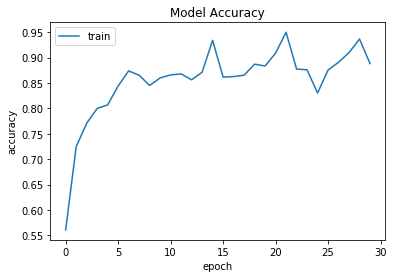

In [154]:
plot_acc(history_vggface)

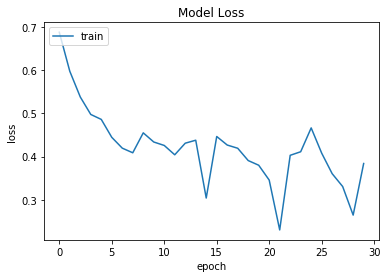

In [155]:
plot_loss(history_vggface)

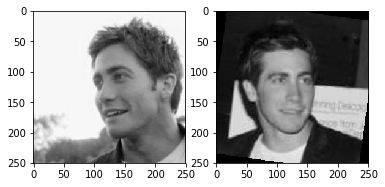

Correct Label: Same Person
Model Prediction: Different Person


In [224]:
test_generator = generator(test_samples, channels=3, batch_size=32, channels_last=False, crop=False)
plot_misclassification_examples(model_vggface, test_generator)